In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import torch
import torch.nn as nn
from torch.optim import Adam

In [3]:
# load dataset
df = pd.read_csv("Fuel_Consumption_2000-2022.csv")

In [4]:
# Select relevant features
features = ['YEAR', 'ENGINE SIZE', 'CYLINDERS', 'FUEL', 'VEHICLE CLASS', 'COMB (L/100 km)']
df = df[features].dropna()

In [5]:
# Encode categorical features
df["FUEL"] = LabelEncoder().fit_transform(df['FUEL'])
df['VEHICLE CLASS'] = LabelEncoder().fit_transform(df['VEHICLE CLASS'])

In [6]:
# Features & Target
X = df.drop('COMB (L/100 km)', axis=1)
y = df['COMB (L/100 km)']

In [7]:
# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Train/test split (temporal awareness)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

In [39]:
# Get the corresponding test years
test_index = df.iloc[int(len(df)*0.8):]['YEAR']
test_index = pd.to_datetime(test_index, format='%Y', errors='coerce').dropna().reset_index(drop=True)

In [11]:
# ======= ML models ========
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}
results = {}
predicted_dict = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    predicted_dict[name] = preds
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = [rmse, mae, r2]

In [13]:
# ======== LSTM model ===========
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=50, output_dim=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

In [14]:
# Reshape input for LSTM: [sample, time steps=1, features]
X_train_lstm = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_lstm = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_lstm = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_lstm = y_test.reset_index(drop=True)

In [15]:
# Reshape input for LSTM: [samples, time steps=1, features]
X_train_lstm = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_test_lstm = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_lstm = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_lstm = y_test.reset_index(drop=True)

In [19]:
# Model, Loss, Optimizer
lstm_model = LSTMModel(input_dim=X_train.shape[1])
loss_fn = nn.MSELoss()
optimizer = Adam(lstm_model.parameters(), lr=0.01)

In [20]:
# Train LSTM
for epoch in range(100):
    lstm_model.train()
    optimizer.zero_grad()
    output = lstm_model(X_train_lstm)
    loss = loss_fn(output, y_train_lstm)
    loss.backward()
    optimizer.step()

In [21]:
# Predict with LSTM
lstm_model.eval()
with torch.no_grad():
    lstm_preds = lstm_model(X_test_lstm).squeeze().numpy()

In [22]:
# Add LSTM results
rmse_lstm = np.sqrt(mean_squared_error(y_test_lstm, lstm_preds))
mae_lstm = mean_absolute_error(y_test_lstm, lstm_preds)
r2_lstm = r2_score(y_test_lstm, lstm_preds)
results['LSTM'] = [rmse_lstm, mae_lstm, r2_lstm]
predicted_dict['LSTM'] = lstm_preds

In [33]:
# =========== Results =============
results_df = pd.DataFrame(results, index=['RMSE', 'MAE', 'R2']).T.reset_index().rename(columns={'index':'Model'})

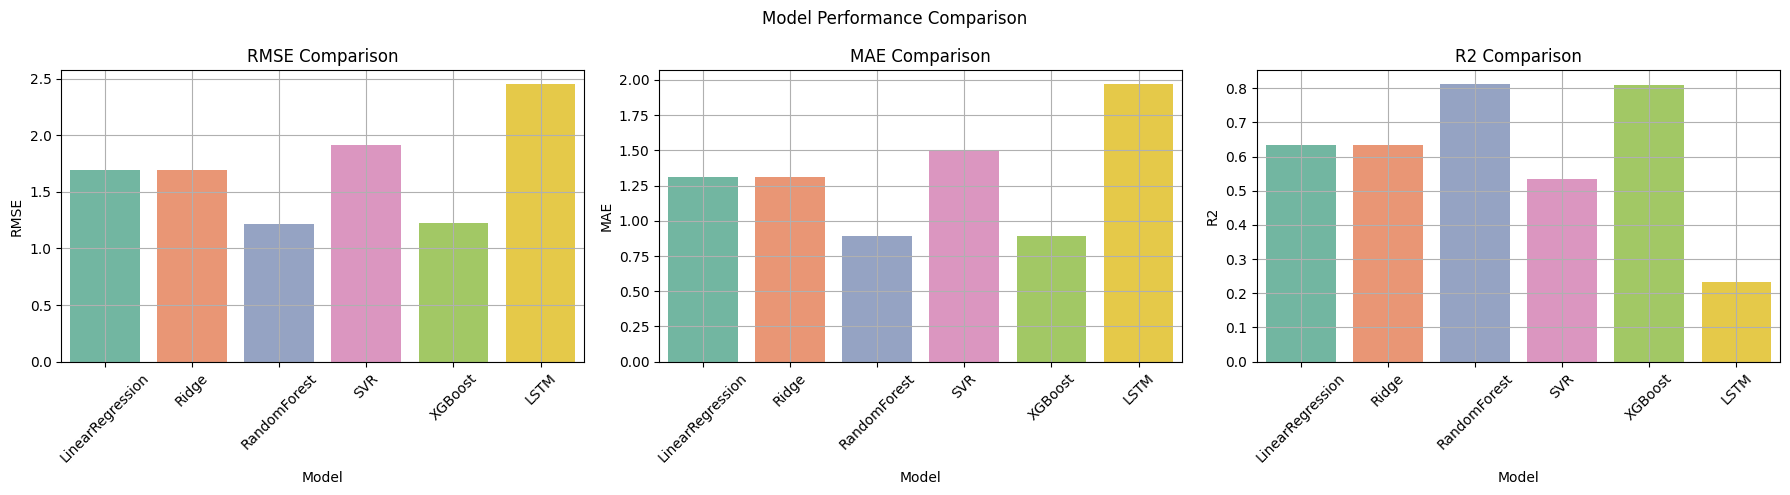

In [30]:
# ✅ Updated Bar Plot (No FutureWarning)
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(['RMSE', 'MAE', 'R2']):
    sns.barplot(
        data=results_df,
        x='Model',
        y=metric,
        hue='Model',         # explicitly define hue
        legend=False,        # suppress extra legend
        ax=ax[i],
        palette='Set2'
    )
    ax[i].set_title(f'{metric} Comparison')
    ax[i].tick_params(axis='x', rotation=45)
    ax[i].grid(True)

plt.suptitle('Model Performance Comparison')
plt.tight_layout()
plt.show()

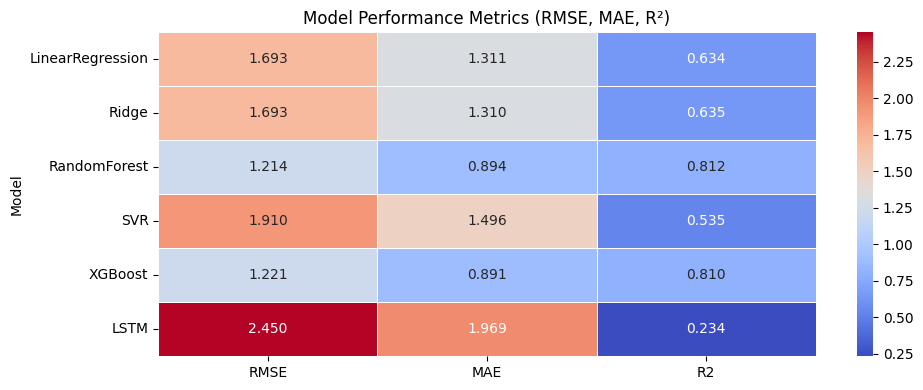

In [29]:
# Heatmap of results
plt.figure(figsize=(10, 4))
sns.heatmap(results_df.set_index('Model'), annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title('Model Performance Metrics (RMSE, MAE, R²)')
plt.tight_layout()
plt.show()

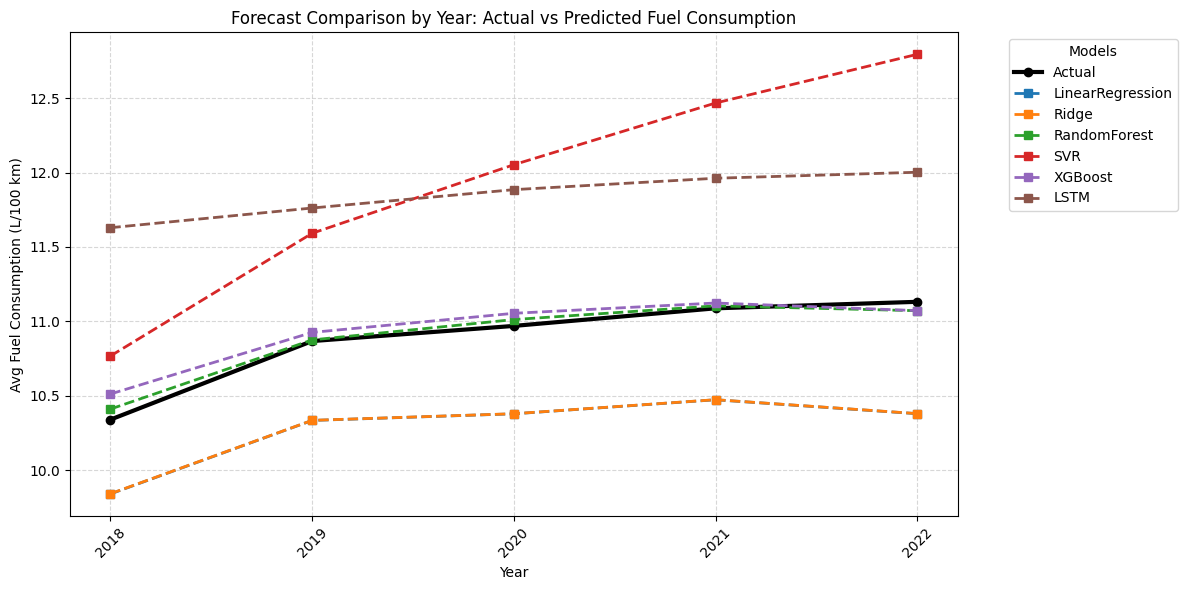

In [46]:
# Ensure 'test_index' is a datetime and drop duplicates
test_index = pd.to_datetime(test_index, errors='coerce')
test_index = test_index.dropna().reset_index(drop=True)

# Extract test years for x-axis
years = test_index.dt.year.unique()

# Map each year to its corresponding prediction values by model
plt.figure(figsize=(12, 6))

# Plot actual values averaged by year
actual_year_avg = pd.DataFrame({'YEAR': test_index.dt.year, 'Actual': y_test.values})
actual_avg = actual_year_avg.groupby('YEAR').mean()
plt.plot(actual_avg.index, actual_avg['Actual'], marker='o', linewidth=3, color='black', label='Actual')

# Plot each model's average per year
for model_name, preds in predicted_dict.items():
    if len(preds) == len(test_index):
        pred_df = pd.DataFrame({'YEAR': test_index.dt.year, model_name: preds})
        pred_avg = pred_df.groupby('YEAR').mean()
        plt.plot(pred_avg.index, pred_avg[model_name], linestyle='--', marker='s', linewidth=2, label=model_name)

plt.title('Forecast Comparison by Year: Actual vs Predicted Fuel Consumption')
plt.xlabel('Year')
plt.ylabel('Avg Fuel Consumption (L/100 km)')
plt.xticks(sorted(actual_avg.index), rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Models', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [34]:
results_df

,Model,RMSE,MAE,R2
0,LinearRegression,1.693025,1.310901,0.634349
1,Ridge,1.692569,1.310293,0.634547
2,RandomForest,1.214444,0.894282,0.811854
3,SVR,1.909788,1.495968,0.534725
4,XGBoost,1.220839,0.891452,0.809868
5,LSTM,2.450123,1.969335,0.234200
